In [1]:
from datasets import load_dataset, concatenate_datasets, Dataset, Features, Value, Sequence, ClassLabel
import pandas as pd
from collections import defaultdict
import random
import hashlib

In [2]:
# preprocessing functions
def normalize_question(q): return q.strip().lower()

def format_mcqa(example, idx, dataset_name, question, options, answer):
    return {
        "id": f"{dataset_name}_{idx}",
        "dataset": dataset_name,
        "question": question.strip(),
        "options": options,
        "answer": answer.strip()
    }

def hash_q(ex):
    """
    Adds a unique identifier (hash) for each MCQA question — in order to detect and remove duplicate questions across datasets.
    """
    ex["question_hash"] = hashlib.md5(normalize_question(ex["question"]).encode()).hexdigest()
    return ex

def format_openbookqa(dataset, score_threshold=1):
    dataset_name = "openbookqa"
    # Filter by human score for high-quality questions
    dataset = dataset.filter(lambda x: x.get("humanScore", 0) >= score_threshold)

    formatted = []
    for idx, ex in enumerate(dataset):
        question = ex["question_stem"]
        options = ex["choices"]["text"]
        answer = ex["answerKey"]
        question_hash = hashlib.md5(normalize_question(question).encode()).hexdigest()

        formatted.append({
            **format_mcqa(ex, idx, dataset_name, question, options, answer),
            "question_hash": question_hash
        })
    return formatted

### Load datasets

In [3]:
# ARC-Challenge
arc = load_dataset("ai2_arc", "ARC-Challenge", split="train")
arc = arc.map(hash_q)
arc_data = [format_mcqa(ex, i, "arc_challenge", ex["question"], ex["choices"]["text"], ex["answerKey"]) for i, ex in enumerate(arc)]

# ARC-Easy
arc_easy = load_dataset("ai2_arc", "ARC-Easy", split="train")
arc_easy = arc_easy.map(hash_q)
arc_easy_data = [format_mcqa(ex, i, "arc_easy", ex["question"], ex["choices"]["text"], ex["answerKey"]) for i, ex in enumerate(arc_easy)]

# QASC
qasc = load_dataset("qasc", split="train").map(hash_q)
qasc_data = [format_mcqa(ex, i, "qasc", ex["question"], ex["choices"]["text"], ex["answerKey"]) for i, ex in enumerate(qasc)]

# OpenBookQA
obqa = load_dataset("openbookqa", "additional", split="train")
obqa_data = format_openbookqa(obqa)

# PubmedQA
pubmed = load_dataset("pubmed_qa", "pqa_labeled", split="train").filter(lambda x: x["final_decision"] in ["yes", "no", "maybe"])
pubmed_data = [
    format_mcqa(ex, i, "pubmedqa", ex["question"], ["yes", "no", "maybe"], ex["final_decision"])
    for i, ex in enumerate(pubmed)
]

In [4]:
print("Number of questions in each dataset:")
print(f"ARC-Challenge: {len(arc_data)}")
print(f"ARC-Easy: {len(arc_easy_data)}")
print(f"QASC: {len(qasc_data)}")
print(f"OpenBookQA: {len(obqa_data)}")
print(f"PubmedQA: {len(pubmed_data)}")

Number of questions in each dataset:
ARC-Challenge: 1119
ARC-Easy: 2251
QASC: 8134
OpenBookQA: 3317
PubmedQA: 1000


In [6]:
# Combine with updated per-source caps based on actual availability
random.seed(42)

def dedup_sample(dataset, seen_hashes, max_size):
    random.shuffle(dataset)
    result = []
    for ex in dataset:
        h = hashlib.md5(normalize_question(ex["question"]).encode()).hexdigest()
        if h not in seen_hashes:
            seen_hashes.add(h)
            result.append(ex)
        if len(result) == max_size:
            break
    return result

seen = set()

final_qasc = dedup_sample(qasc_data, seen, 3000)

final_combined = arc_data + arc_easy_data + final_qasc + obqa_data + pubmed_data
random.shuffle(final_combined)

# Save as HuggingFace Dataset
final_mcqa = Dataset.from_list(final_combined)
final_mcqa.save_to_disk("mcqa_dataset_mnlp")

Saving the dataset (0/1 shards):   0%|          | 0/10687 [00:00<?, ? examples/s]

In [ ]:
# Remove the question_hash field from each example
for ex in final_combined:
    ex.pop("question_hash", None)

# Save as HuggingFace Dataset
final_mcqa = Dataset.from_list(final_combined)
print(f"Final dataset size: {len(final_mcqa)}")
print(final_mcqa[0]) 
final_mcqa.save_to_disk("mcqa_dataset_mnlp")

Final dataset size: 10687
{'id': 'openbookqa_2211', 'dataset': 'openbookqa', 'question': 'A fallen tree may provide what?', 'options': ['Hope', 'Happiness', 'Love', 'Thriving life'], 'answer': 'D'}


Saving the dataset (0/1 shards):   0%|          | 0/10687 [00:00<?, ? examples/s]

In [8]:
final_mcqa.push_to_hub(
    "GingerBled/MNLP_M2_mcqa_dataset"
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/420 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/GingerBled/MNLP_M2_mcqa_dataset/commit/6f8047f9c274bcd369f8912de2ca5aaa1bc91a0c', commit_message='Upload dataset', commit_description='', oid='6f8047f9c274bcd369f8912de2ca5aaa1bc91a0c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/GingerBled/MNLP_M2_mcqa_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='GingerBled/MNLP_M2_mcqa_dataset'), pr_revision=None, pr_num=None)

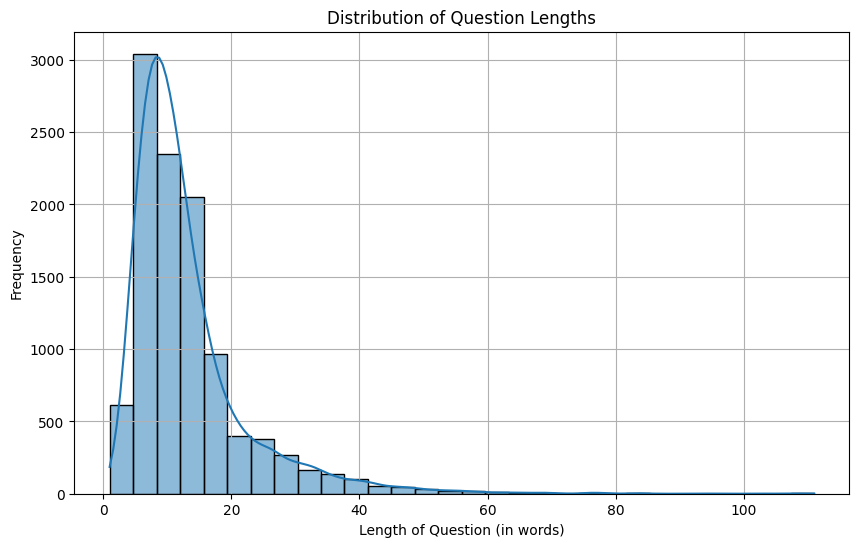

In [11]:
# plot sequence length distribution
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_sequence_length_distribution(dataset):
    # Calculate the length of each question
    lengths = [len(ex["question"].split()) for ex in dataset]

    # Create a histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, bins=30, kde=True)
    plt.title("Distribution of Question Lengths")
    plt.xlabel("Length of Question (in words)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

plot_sequence_length_distribution(final_mcqa)